In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from imp import reload
import torch.nn as nn

import sys
sys.path.append("..")
import vnn
import vec_models
import nonvec_models
import train_models
from scipy.stats import pearsonr
reload(vnn)
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
#results[DSET][MODEL][METHOD][SIGN]

In [18]:
train_loader, test_loader = train_models.load_cifar(128, shuffle_train=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
labels = np.zeros(50000)
i = 0
for (x, y) in train_loader:
    labels[i:i+len(y)] = y
    i += len(y)

In [27]:
labels

array([6., 9., 9., ..., 9., 1., 1.])

In [40]:
def do_pca(X, num_pcs):
    print(X.shape, 'pca')
    X -= X.mean(axis=0)
    pca = PCA(n_components=num_pcs)
    X_pca = pca.fit_transform(X)
    return X_pca

def compute_conv_output(make_model_fn, checkpoint_path, loader, truncate_layer, vectorized):
    model = make_model_fn()
    model = model.to(0)
    checkpoint = torch.load(checkpoint_path)
    strict = vectorized or (not vectorized and '_bp_' in checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'], strict=strict)
    if not vectorized:
        truncated_model = model.sequential[:truncate_layer]
    else:
        truncated_model = model[:truncate_layer]
    full_output = None
    full_labels = np.zeros(50000)
    i = 0
    for data, labels in train_loader:
        input = vnn.expand_input_conv(data, 10) if vectorized else data
        with torch.no_grad():
            output = truncated_model(input.to(0))
        output = output.view(len(output), -1).cpu().numpy()
        if full_output is None:
            full_output = np.zeros((50000, output.shape[1]))
        full_output[i:i+len(output)] = output
        full_labels[i:i+len(output)] = labels
        i = i + len(output)
    pca_output = do_pca(full_output, 600)
    return pca_output, full_labels

def compute_all_reps(base_dir, model_name, make_model_fn, truncate_layer, loader, vectorized):
    reps = None
    for run_idx in range(5):
        print('run', run_idx)
        model_dir = os.path.join(base_dir, 'models_' + str(run_idx), model_name)
        epoch_dirs = os.listdir(model_dir)
        epochs = np.sort([int(name.split('.')[0].split('_')[1]) for name in epoch_dirs])
        last_epoch = np.max(epochs)
        checkpoint_path_1 = os.path.join(model_dir, 'epoch_0.pt')
        checkpoint_path_2 = os.path.join(model_dir, 'epoch_{}.pt'.format(last_epoch))
        output_1, labels_1 = compute_conv_output(make_model_fn, checkpoint_path_1, loader, truncate_layer, vectorized)
        output_2, labels_2 = compute_conv_output(make_model_fn, checkpoint_path_2, loader, truncate_layer, vectorized)
        print('label sanity check', np.sum(labels_1 == labels_2))
        if reps is None:
            reps = np.zeros((5, 2, 50000, output_1.shape[1]))
        reps[run_idx, 0] = output_1
        reps[run_idx, 1] = output_2
    labels = labels_1
    return reps, labels




In [41]:
base_dir = "/media/davidclark/DATA/VectorizedNets/"

reps, labels = compute_all_reps(
    base_dir, 'cifar_nonvec_conv_bp_mixed', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    truncate_layer=12, loader=train_loader, vectorized=False)
np.savez('tsne_data/pca/cifar_nonvec_conv_bp_mixed.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_nonvec_conv_bp_mono', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    truncate_layer=12, loader=train_loader, vectorized=False)
np.savez('tsne_data/pca/cifar_nonvec_conv_bp_mono.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_nonvec_conv_df_mixed', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    truncate_layer=12, loader=train_loader, vectorized=False)
np.savez('tsne_data/pca/cifar_nonvec_conv_df_mixed.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_nonvec_conv_df_mono', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    truncate_layer=12, loader=train_loader, vectorized=False)
np.savez('tsne_data/pca/cifar_nonvec_conv_df_mono.npz', reps=reps.astype(np.float32), labels=labels)

run 0
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 1
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 2
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 3
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 4
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 0
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 1
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 2
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 3
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000
run 4
(50000, 1024) pca
(50000, 1024) pca
label sanity check 50000


In [42]:
reps, labels = compute_all_reps(
    base_dir, 'cifar_vec_conv_bp_mixed', lambda: vec_models.make_cifar_vec_conv(False),
    truncate_layer=9, loader=train_loader, vectorized=True)
np.savez('tsne_data/pca/cifar_vec_conv_bp_mixed.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_vec_conv_bp_mono', lambda: vec_models.make_cifar_vec_conv(False),
    truncate_layer=9, loader=train_loader, vectorized=True)
np.savez('tsne_data/pca/cifar_vec_conv_bp_mono.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_vec_conv_df_mixed', lambda: vec_models.make_cifar_vec_conv(False),
    truncate_layer=9, loader=train_loader, vectorized=True)
np.savez('tsne_data/pca/cifar_vec_conv_df_mixed.npz', reps=reps.astype(np.float32), labels=labels)

reps, labels = compute_all_reps(
    base_dir, 'cifar_vec_conv_df_mono', lambda: vec_models.make_cifar_vec_conv(False),
    truncate_layer=9, loader=train_loader, vectorized=True)
np.savez('tsne_data/pca/cifar_vec_conv_df_mono.npz', reps=reps.astype(np.float32), labels=labels)

run 0
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 1
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 2
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 3
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 4
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 0
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 1
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 2
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 3
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 4
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 0
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 1
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 2
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 3
(50000, 10240) pca
(50000, 10240) pca
label sanity check 50000
run 4
(50000, 10240) pca
(50000, 1

In [264]:
X_1 = np.load('tsne_data/pca/cifar_nonvec_conv_df_mono.npz')['reps']
X_2 = np.load('tsne_data/pca/cifar_nonvec_conv_df_mixed.npz')['reps']
X_3 = np.load('tsne_data/pca/cifar_nonvec_conv_bp_mono.npz')['reps']
X_4 = np.load('tsne_data/pca/cifar_nonvec_conv_bp_mixed.npz')['reps']
print('Done...')

X_5 = np.load('tsne_data/pca/cifar_vec_conv_df_mono.npz')['reps']
X_6 = np.load('tsne_data/pca/cifar_vec_conv_df_mixed.npz')['reps']
X_7 = np.load('tsne_data/pca/cifar_vec_conv_bp_mono.npz')['reps']
data_8 = np.load('tsne_data/pca/cifar_vec_conv_bp_mixed.npz')
X_8 = data_8['reps']

labels = data_8['labels']

Done...


In [266]:
X_1.shape

(5, 2, 50000, 600)

In [333]:
def rms_dists(X):
    #https://stackoverflow.com/questions/55957844/memory-efficient-mean-pairwise-distance
    d = np.sqrt(np.var(X, 0, ddof=1).sum()*2)
    return d

def rms_dists_classes(X, labels):
    d_vals = np.zeros(10)
    for i in range(10):
        mask = labels == i
        X_i = X[mask]
        d_vals[i] = rms_dists(X_i)
    return d_vals.mean()

def perform_tsne(X):
    tsne_model = TSNE(n_components=2, perplexity=20, learning_rate=100, n_iter=5000, device=0)
    X_tsne = tsne_model.fit_transform(X)
    return X_tsne

def tsne_d(X, labels):
    X_tsne = perform_tsne(X)
    d = rms_dists_classes(X_tsne, labels) / rms_dists(X_tsne)
    return d, X_tsne
    
def tsne_d_vals(X_12, labels):
    d1, X_tsne_1 = tsne_d(X_12[0], labels)
    d2, X_tsne_2 = tsne_d(X_12[1], labels)
    print(d1, d2)
    return d1, d2, X_tsne_1, X_tsne_2
    

In [334]:
results = np.zeros((8, 5, 2))
all_X = (X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8)
saved_tsnes = []

for i in range(8):
    X = all_X[i]
    for run_idx in range(5):
        print(i, run_idx)
        d1, d2, X_tsne_1, X_tsne_2 = tsne_d_vals(X[run_idx], labels)
        results[i, run_idx] = (d1, d2)
        if (i == 0 or i == 4) and run_idx == 0:
            saved_tsnes.append((X_tsne_1, X_tsne_2))
        



0 0
0.9424381933145145 0.9209844278552956
0 1
0.9266203558866505 0.9066533312700445
0 2
0.926760832512733 0.939072398277403
0 3
0.9460479298079413 0.9376130327739399
0 4
0.9435236717143456 0.9514578651912373
1 0
0.9478263376636451 0.925392922752345
1 1
0.9402577844614548 0.9188303944199337
1 2
0.9410220664319674 0.9151266410019647
1 3
0.937966717177078 0.9184489196424073
1 4
0.9282928657558228 0.9193927671435003
2 0
0.9460516294538578 0.838199126862028
2 1
0.9409772228399286 0.7981320508909278
2 2
0.9396082314288774 0.7907801560723671
2 3
0.9301692108684633 0.795294037664379
2 4
0.9250724930139115 0.7940473089984458
3 0
0.9330110676289122 0.7497643704728767
3 1
0.9379387919879146 0.7732221541199653
3 2
0.9205792090096899 0.766605983984557
3 3
0.9412226148380116 0.7424787385685676
3 4
0.9254254214409876 0.7412288522144953
4 0
0.9163482361833639 0.7226375703274202
4 1
0.92494738378875 0.7311397395642646
4 2
0.9234516972958254 0.7568349890886095
4 3
0.9207236490149795 0.7492548934384724
4

In [4]:
diffs = results[:, :, 0] - results[:, :, 1]
diffs = diffs[[4, 6, 5, 7, 0, 2, 1, 3]]


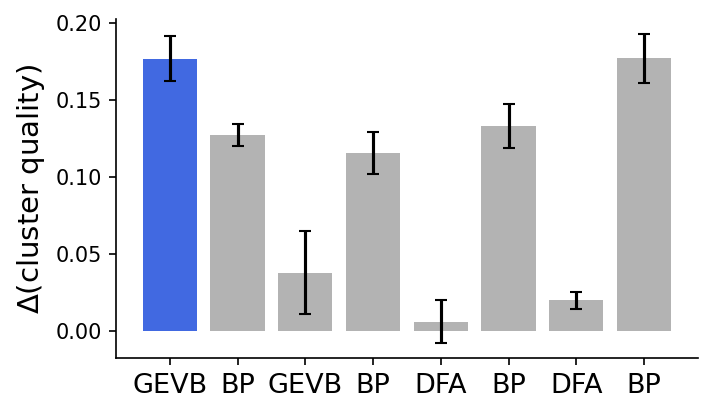

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=150)
ax.bar(x=np.arange(8), height=diffs.mean(axis=1), yerr=diffs.std(axis=1),
       capsize=3, color=['royalblue']+['0.7']*7)

ticklabels = ['GEVB', 'BP', 'GEVB', 'BP', 'DFA', 'BP', 'DFA', 'BP']
ax.set_xticks(np.arange(8))
ax.set_xticklabels(ticklabels, size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.text(1.5, -.05, 'Vectorized', ha='center', va='top', fontsize=14)
#ax.text(5.5, -.05, 'Conventional', ha='center', va='top', fontsize=14)
ax.set_ylabel('$\Delta$(cluster quality)', size=14)

plt.savefig('figs/cifar_bar_plot.pdf', bbox_inches='tight')


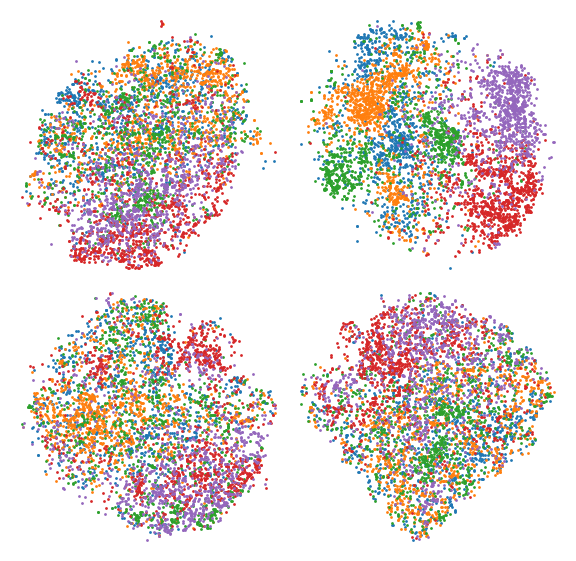

In [31]:
def scatter_tsne(ax, X, labels):
    X, labels = X[:10000], labels[:10000]
    for i in range(5, 10):
        mask = labels == i
        X_i = X[mask]
        ax.scatter(X_i[:, 0], X_i[:, 1], lw=0, s=5)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), dpi=90)
fig.subplots_adjust(wspace=0, hspace=0)
for ax in axes.flatten():
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
scatter_tsne(axes[0, 0], saved_tsnes[1][0], labels)
scatter_tsne(axes[0, 1], saved_tsnes[1][1], labels)

scatter_tsne(axes[1, 0], saved_tsnes[0][0], labels)
scatter_tsne(axes[1, 1], saved_tsnes[0][1], labels)

#axes[0, 0].set_ylabel("Conv-Vec\nDF+", rotation=0, fontsize=16, labelpad=14, color='purple')
#axes[1, 0].set_ylabel("Conv\nDF+", rotation=0, fontsize=16, labelpad=14)
#axes[0, 0].set_title("initialization", fontsize=16)
#axes[0, 1].set_title("trained", fontsize=16)

plt.savefig('figs/cifar_tsnes.png', bbox_inches='tight', dpi=190)


In [3]:
#np.savez('tsne_data/tsnes.npz', saved_tsnes=np.array(saved_tsnes), results=results)

data = np.load('tsne_data/tsnes.npz', 'r')
saved_tsnes = data['saved_tsnes']
results = data['results']